In [1]:
# 测试修复后的C++代码 - 运行完整测试
import numpy as np
import sequenzo.clustering.clustering_c_code as clustering_c_code
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# 1. 首先构建cluster对象
# Import necessary libraries
from sequenzo import * # Import the package, give it a short alias
import pandas as pd # Data manipulation

# Load the mvad dataset
df = load_dataset('mvad')

# Define time variables and states
time_list = ['Jul.93', 'Aug.93', 'Sep.93', 'Oct.93', 'Nov.93', 'Dec.93',
       'Jan.94', 'Feb.94', 'Mar.94', 'Apr.94', 'May.94', 'Jun.94', 'Jul.94',
       'Aug.94', 'Sep.94', 'Oct.94', 'Nov.94', 'Dec.94', 'Jan.95', 'Feb.95',
       'Mar.95', 'Apr.95', 'May.95', 'Jun.95', 'Jul.95', 'Aug.95', 'Sep.95',
       'Oct.95', 'Nov.95', 'Dec.95', 'Jan.96', 'Feb.96', 'Mar.96', 'Apr.96',
       'May.96', 'Jun.96', 'Jul.96', 'Aug.96', 'Sep.96', 'Oct.96', 'Nov.96',
       'Dec.96', 'Jan.97', 'Feb.97', 'Mar.97', 'Apr.97', 'May.97', 'Jun.97',
       'Jul.97', 'Aug.97', 'Sep.97', 'Oct.97', 'Nov.97', 'Dec.97', 'Jan.98',
       'Feb.98', 'Mar.98', 'Apr.98', 'May.98', 'Jun.98', 'Jul.98', 'Aug.98',
       'Sep.98', 'Oct.98', 'Nov.98', 'Dec.98', 'Jan.99', 'Feb.99', 'Mar.99',
       'Apr.99', 'May.99', 'Jun.99']

states = ['FE', 'HE', 'employment', 'joblessness', 'school', 'training']
labels = ['further education', 'higher education', 'employment', 'joblessness', 'school', 'training']

# Create sequence data
sequence_data = SequenceData(df, 
                             time=time_list, 
                             id_col="id", 
                             states=states,
                             labels=labels)

print("Sequence data created successfully!")

# Create distance matrix
om = get_distance_matrix(sequence_data, 
                        method="OM", 
                        sm="CONSTANT", 
                        indel=1)

print("Distance matrix computed!")

# Create cluster object
cluster = Cluster(om, sequence_data.ids, clustering_method='ward')
print("Cluster object created!")

# 2. 现在测试修复后的C++代码
condensed = squareform(cluster.full_matrix)
labels = fcluster(cluster.linkage_matrix, 7, criterion="maxclust")  # 使用7个聚类作为例子

# 直接调用C++函数
result = clustering_c_code.cluster_quality_condensed(
    condensed.astype(np.float64, copy=False),
    labels.astype(np.int32, copy=False),
    cluster.weights.astype(np.float64, copy=False),
    cluster.full_matrix.shape[0],
    7
)

print("C++返回的修复后的值:")
for key, value in result.items():
    print(f"{key}: {value}")
    
print("\n与R结果对比 (cluster7):")
print("R - ASW: 0.31, ASWw: 0.32, HG: 0.80, PBC: 0.54, CH: 136.64, R2: 0.54, HC: 0.11")
print(f"C++ - ASW: {result['ASW']:.2f}, ASWw: {result['ASWw']:.2f}, HG: {result['HG']:.2f}, PBC: {result['PBC']:.2f}, CH: {result['CH']:.2f}, R2: {result['R2']:.2f}, HC: {result['HC']:.2f}")

# 计算差值
print("\n差值 (C++ - R):")
r_values = {'ASW': 0.31, 'ASWw': 0.32, 'HG': 0.80, 'PBC': 0.54, 'CH': 136.64, 'R2': 0.54, 'HC': 0.11}
for key in ['ASW', 'ASWw', 'HG', 'PBC', 'CH', 'R2', 'HC']:
    if key in result:
        diff = result[key] - r_values[key]
        print(f"{key}: {diff:.3f}")

print("Testing completed!")



[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 712
[>] Number of time points: 72
[>] Min/Max sequence length: 72 / 72
[>] States: ['FE', 'HE', 'employment', 'joblessness', 'school', 'training']
[>] Labels: ['further education', 'higher education', 'employment', 'joblessness', 'school', 'training']
[>] Weights: Not provided
Sequence data created successfully!
[>] Processing 712 sequences with 6 unique states.
  - Creating 7x7 substitution-cost matrix using 2 as constant value
[>] Identified 557 unique sequences.
[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.
Distance matrix computed!
[>] Converting DataFrame to NumPy array...
[>] Note: 'ward' method maps to 'ward_d' (classic Ward method).
    Use 'ward_d2' for Ward method with squared Euclidean distances.
[>] Applied Ward D correction: distances divided by 2 for classic Ward method.
Cluster object created!
C++返回的修复后的值:
PBC: 0.639789663016147

In [2]:
# 精确对比：在相同聚类数下比较Python和R结果
import numpy as np

# R结果数据 (手动收集的关键聚类数结果)
r_results = {
    2: {'ASW': 0.4250999, 'ASWw': 0.4265209, 'CH': 209.8160836, 'CHsq': 420.2477290, 'HC': 0.0654802},
    3: {'CH': 181.28235060},
    4: {'PBC': 0.65213147},
    6: {'ASW': 0.37908685, 'ASWw': 0.38392161, 'PBC': 0.6683922},
    8: {'CHsq': 382.81257049},
    19: {'HG': 0.90386324, 'HGSD': 0.90081055, 'R2': 0.70500521, 'R2sq': 0.88124267, 'HC': 0.06765768},
    20: {'HG': 0.9079649, 'HGSD': 0.9049400, 'R2': 0.7108317, 'R2sq': 0.8873754, 'HC': 0.0654802}
}

# 测试关键聚类数
test_clusters = [2, 3, 4, 6, 8, 19, 20]

print("完整对比 - Python vs R (完整指标集)")
print("=" * 80)

all_metrics = ['PBC', 'HG', 'HGSD', 'ASW', 'ASWw', 'CH', 'R2', 'CHsq', 'R2sq', 'HC']

for n_clusters in test_clusters:
    print(f"\n聚类数: {n_clusters}")
    print("-" * 50)
    
    # 获取cluster labels
    labels = fcluster(cluster.linkage_matrix, n_clusters, criterion="maxclust")
    
    # 调用C++函数
    result = clustering_c_code.cluster_quality_condensed(
        condensed.astype(np.float64, copy=False),
        labels.astype(np.int32, copy=False),
        cluster.weights.astype(np.float64, copy=False),
        cluster.full_matrix.shape[0],
        n_clusters
    )
    
    # 对比所有指标
    for metric in all_metrics:
        if metric in result:
            python_val = result[metric]
            print(f"{metric:5s}: Python={python_val:.8f}", end="")
            
            # 如果有R对应值，显示差异
            if n_clusters in r_results and metric in r_results[n_clusters]:
                r_val = r_results[n_clusters][metric]
                diff = python_val - r_val
                diff_pct = (diff / r_val * 100) if r_val != 0 else float('inf')
                print(f"  |  R={r_val:.8f}  |  Diff={diff:.8f} ({diff_pct:+.2f}%)")
            else:
                print()

# 重点关注最大差异
print("\n" + "=" * 80)
print("重点分析：最大差异的指标")
print("=" * 80)

max_diffs = []
for n_clusters in test_clusters:
    if n_clusters in r_results:
        labels = fcluster(cluster.linkage_matrix, n_clusters, criterion="maxclust")
        result = clustering_c_code.cluster_quality_condensed(
            condensed.astype(np.float64, copy=False),
            labels.astype(np.int32, copy=False),
            cluster.weights.astype(np.float64, copy=False),
            cluster.full_matrix.shape[0],
            n_clusters
        )
        
        for metric in r_results[n_clusters]:
            if metric in result:
                r_val = r_results[n_clusters][metric]
                python_val = result[metric]
                diff_pct = abs((python_val - r_val) / r_val * 100) if r_val != 0 else 0
                max_diffs.append((diff_pct, metric, n_clusters, python_val, r_val))

# 排序并显示最大差异
max_diffs.sort(reverse=True)
print("前10个最大差异:")
for i, (diff_pct, metric, n_clusters, python_val, r_val) in enumerate(max_diffs[:10]):
    print(f"{i+1:2d}. {metric} (k={n_clusters}): {diff_pct:.2f}% - Python={python_val:.6f}, R={r_val:.6f}")


完整对比 - Python vs R (完整指标集)

聚类数: 2
--------------------------------------------------
PBC  : Python=0.40945487
HG   : Python=0.47333027
HGSD : Python=0.46811798
ASW  : Python=0.28301301  |  R=0.42509990  |  Diff=-0.14208689 (-33.42%)
ASWw : Python=0.28493480  |  R=0.42652090  |  Diff=-0.14158610 (-33.20%)
CH   : Python=155.38302918  |  R=209.81608360  |  Diff=-54.43305442 (-25.94%)
R2   : Python=0.17955405
CHsq : Python=24143.88575664  |  R=420.24772900  |  Diff=23723.63802764 (+5645.16%)
R2sq : Python=0.03223966
HC   : Python=0.26092942  |  R=0.06548020  |  Diff=0.19544922 (+298.49%)

聚类数: 3
--------------------------------------------------
PBC  : Python=0.51015255
HG   : Python=0.60135964
HGSD : Python=0.59646711
ASW  : Python=0.31778244
ASWw : Python=0.32051088
CH   : Python=157.78346454  |  R=181.28235060  |  Diff=-23.49888606 (-12.96%)
R2   : Python=0.30800031
CHsq : Python=24895.62168114
R2sq : Python=0.09486419
HC   : Python=0.19810693

聚类数: 4
----------------------------------

In [3]:
# 深度调试：检查数据格式和潜在差异源
import numpy as np

# 选择一个特定聚类数进行详细分析 (k=2, 因为差异可能最明显)
k = 2
labels = fcluster(cluster.linkage_matrix, k, criterion="maxclust")

print("=== 数据格式调试 ===")
print(f"距离矩阵形状: {cluster.full_matrix.shape}")
print(f"压缩距离矩阵长度: {len(condensed)}")
print(f"聚类标签范围: {labels.min()} - {labels.max()}")
print(f"聚类标签类型: {labels.dtype}")
print(f"权重总和: {cluster.weights.sum()}")
print(f"权重类型: {cluster.weights.dtype}")

print(f"\n聚类分布 (k={k}):")
unique, counts = np.unique(labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  聚类 {u}: {c} 个样本")

print("\n=== 检查聚类标签一致性 ===")
# 确保标签是连续的1, 2, ..., k
expected_labels = set(range(1, k+1))
actual_labels = set(labels)
print(f"期望标签: {expected_labels}")
print(f"实际标签: {actual_labels}")
print(f"标签一致: {expected_labels == actual_labels}")

print("\n=== 测试不同输入格式 ===")
# 测试1: 原始调用
result1 = clustering_c_code.cluster_quality_condensed(
    condensed.astype(np.float64, copy=False),
    labels.astype(np.int32, copy=False),
    cluster.weights.astype(np.float64, copy=False),
    cluster.full_matrix.shape[0],
    k
)

# 测试2: 强制复制数组
result2 = clustering_c_code.cluster_quality_condensed(
    condensed.astype(np.float64, copy=True),
    labels.astype(np.int32, copy=True),
    cluster.weights.astype(np.float64, copy=True),
    cluster.full_matrix.shape[0],
    k
)

# 测试3: 使用不同的数据类型
result3 = clustering_c_code.cluster_quality_condensed(
    condensed.astype(np.double),
    labels.astype(np.int32),
    cluster.weights.astype(np.double),
    cluster.full_matrix.shape[0],
    k
)

print("测试结果一致性:")
for key in result1:
    v1, v2, v3 = result1[key], result2[key], result3[key]
    if isinstance(v1, np.ndarray):
        consistent = np.allclose(v1, v2) and np.allclose(v1, v3)
    else:
        consistent = (abs(v1 - v2) < 1e-10) and (abs(v1 - v3) < 1e-10)
    print(f"  {key}: {consistent}")

print(f"\n=== k={k} 的详细结果 ===")
for key in ['ASW', 'ASWw', 'CH', 'CHsq', 'HC']:
    if key in result1:
        print(f"{key}: {result1[key]:.10f}")

# 与R结果对比 (k=2)
r_k2 = {'ASW': 0.4250999, 'ASWw': 0.4265209, 'CH': 209.8160836, 'CHsq': 420.2477290, 'HC': 0.0654802}
print(f"\nR vs Python 差异 (k={k}):")
for key in r_k2:
    if key in result1:
        diff = result1[key] - r_k2[key]
        diff_pct = (diff / r_k2[key] * 100) if r_k2[key] != 0 else float('inf')
        print(f"  {key}: Python={result1[key]:.8f}, R={r_k2[key]:.8f}, 差异={diff:.8f} ({diff_pct:+.3f}%)")


=== 数据格式调试 ===
距离矩阵形状: (712, 712)
压缩距离矩阵长度: 253116
聚类标签范围: 1 - 2
聚类标签类型: int32
权重总和: 712.0
权重类型: float64

聚类分布 (k=2):
  聚类 1: 375 个样本
  聚类 2: 337 个样本

=== 检查聚类标签一致性 ===
期望标签: {1, 2}
实际标签: {1, 2}
标签一致: True

=== 测试不同输入格式 ===
测试结果一致性:
  PBC: True
  HG: True
  HGSD: True
  ASW: True
  ASWw: True
  CH: True
  R2: True
  CHsq: True
  R2sq: True
  HC: True
  cluster_asw: True

=== k=2 的详细结果 ===
ASW: 0.2830130054
ASWw: 0.2849347998
CH: 155.3830291784
CHsq: 24143.8857566428
HC: 0.2609294184

R vs Python 差异 (k=2):
  ASW: Python=0.28301301, R=0.42509990, 差异=-0.14208689 (-33.424%)
  ASWw: Python=0.28493480, R=0.42652090, 差异=-0.14158610 (-33.196%)
  CH: Python=155.38302918, R=209.81608360, 差异=-54.43305442 (-25.943%)
  CHsq: Python=24143.88575664, R=420.24772900, 差异=23723.63802764 (+5645.156%)
  HC: Python=0.26092942, R=0.06548020, 差异=0.19544922 (+298.486%)


In [4]:
# Import necessary libraries
# Your calling code (e.g., in a script or notebook)

from sequenzo import * # Import the package, give it a short alias
import pandas as pd # Data manipulation

# List all the available datasets in Sequenzo
# Now access functions using the alias:
print('Available datasets in Sequenzo: ', list_datasets())

# Load the data that we would like to explore in this tutorial
# `df` is the short for `dataframe`, which is a common variable name for a dataset
# df = load_dataset('country_co2_emissions')
df = load_dataset('mvad')

# Show the dataframe
df

Available datasets in Sequenzo:  ['country_co2_emissions_local_quintiles', 'country_co2_emissions_local_deciles', 'polyadic_seqc1', 'polyadic_samplep1', 'mvad', 'chinese_colonial_territories', 'polyadic_samplec1', 'country_gdp_per_capita', 'polyadic_seqp1', 'country_co2_emissions', 'biofam_married_domain', 'country_co2_emissions_global_deciles', 'country_co2_emissions_global_quintiles', 'biofam', 'pairfam_family', 'biofam_left_domain', 'biofam_child_domain']


,id,weight,male,catholic,Belfast,N.Eastern,Southern,S.Eastern,Western,Grammar,...,Sep.98,Oct.98,Nov.98,Dec.98,Jan.99,Feb.99,Mar.99,Apr.99,May.99,Jun.99
0,1,0.33,no,no,no,no,no,no,yes,no,...,employment,employment,employment,employment,employment,employment,employment,employment,employment,employment
1,2,0.57,no,no,no,no,no,no,yes,no,...,HE,HE,HE,HE,HE,HE,HE,HE,HE,HE
2,3,1.59,yes,yes,no,no,no,no,yes,no,...,employment,employment,employment,employment,employment,employment,employment,employment,joblessness,joblessness
3,4,1.59,no,no,no,no,no,no,yes,no,...,employment,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness
4,5,0.57,yes,no,no,no,no,no,yes,no,...,HE,HE,HE,HE,HE,HE,HE,HE,HE,HE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,708,0.69,yes,no,no,no,yes,no,no,yes,...,employment,HE,HE,HE,HE,HE,HE,HE,HE,HE
708,709,0.69,yes,no,no,no,yes,no,no,yes,...,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness
709,710,1.31,no,no,no,no,yes,no,no,yes,...,HE,HE,HE,HE,HE,HE,HE,HE,HE,HE
710,711,0.98,yes,yes,no,no,yes,no,no,no,...,employment,employment,employment,employment,employment,employment,employment,employment,employment,employment


In [5]:
# 获取所有唯一的状态值
import pandas as pd

# 时间列表
time_list = ['Jul.93', 'Aug.93', 'Sep.93', 'Oct.93', 'Nov.93', 'Dec.93',
       'Jan.94', 'Feb.94', 'Mar.94', 'Apr.94', 'May.94', 'Jun.94', 'Jul.94',
       'Aug.94', 'Sep.94', 'Oct.94', 'Nov.94', 'Dec.94', 'Jan.95', 'Feb.95',
       'Mar.95', 'Apr.95', 'May.95', 'Jun.95', 'Jul.95', 'Aug.95', 'Sep.95',
       'Oct.95', 'Nov.95', 'Dec.95', 'Jan.96', 'Feb.96', 'Mar.96', 'Apr.96',
       'May.96', 'Jun.96', 'Jul.96', 'Aug.96', 'Sep.96', 'Oct.96', 'Nov.96',
       'Dec.96', 'Jan.97', 'Feb.97', 'Mar.97', 'Apr.97', 'May.97', 'Jun.97',
       'Jul.97', 'Aug.97', 'Sep.97', 'Oct.97', 'Nov.97', 'Dec.97', 'Jan.98',
       'Feb.98', 'Mar.98', 'Apr.98', 'May.98', 'Jun.98', 'Jul.98', 'Aug.98',
       'Sep.98', 'Oct.98', 'Nov.98', 'Dec.98', 'Jan.99', 'Feb.99', 'Mar.99',
       'Apr.99', 'May.99', 'Jun.99']

# 方法1: 使用pandas获取所有唯一值
time_states_df = df[time_list]
all_unique_states = set()

for col in time_list:
    unique_vals = df[col].dropna().unique()  # Remove NaN values
    all_unique_states.update(unique_vals)

# 转换为排序的列表
states = sorted(list(all_unique_states))
print("All unique states:")
for i, state in enumerate(states, 1):
    print(f"{i:2d}. {state}")

print(f"\nstates list:")
print(f"states = {states}")

All unique states:
 1. FE
 2. HE
 3. employment
 4. joblessness
 5. school
 6. training

states list:
states = ['FE', 'HE', 'employment', 'joblessness', 'school', 'training']


In [6]:
# Create a SequenceData object

# Define the time-span variable
time_list = ['Jul.93', 'Aug.93', 'Sep.93', 'Oct.93', 'Nov.93', 'Dec.93',
       'Jan.94', 'Feb.94', 'Mar.94', 'Apr.94', 'May.94', 'Jun.94', 'Jul.94',
       'Aug.94', 'Sep.94', 'Oct.94', 'Nov.94', 'Dec.94', 'Jan.95', 'Feb.95',
       'Mar.95', 'Apr.95', 'May.95', 'Jun.95', 'Jul.95', 'Aug.95', 'Sep.95',
       'Oct.95', 'Nov.95', 'Dec.95', 'Jan.96', 'Feb.96', 'Mar.96', 'Apr.96',
       'May.96', 'Jun.96', 'Jul.96', 'Aug.96', 'Sep.96', 'Oct.96', 'Nov.96',
       'Dec.96', 'Jan.97', 'Feb.97', 'Mar.97', 'Apr.97', 'May.97', 'Jun.97',
       'Jul.97', 'Aug.97', 'Sep.97', 'Oct.97', 'Nov.97', 'Dec.97', 'Jan.98',
       'Feb.98', 'Mar.98', 'Apr.98', 'May.98', 'Jun.98', 'Jul.98', 'Aug.98',
       'Sep.98', 'Oct.98', 'Nov.98', 'Dec.98', 'Jan.99', 'Feb.99', 'Mar.99',
       'Apr.99', 'May.99', 'Jun.99']

states = ['FE', 'HE', 'employment', 'joblessness', 'school', 'training']
labels = ['further education', 'higher education', 'employment', 'joblessness', 'school', 'training']

# TODO: write a try and error: if no such a parameter, then ask to pass the right ones
# sequence_data = SequenceData(df, time=time, time_type="year", id_col="country", ids=df['country'].values, states=states)

sequence_data = SequenceData(df, 
                             time=time_list, 
                             id_col="id", 
                             states=states,
                             labels=labels,
                             )

sequence_data


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 712
[>] Number of time points: 72
[>] Min/Max sequence length: 72 / 72
[>] States: ['FE', 'HE', 'employment', 'joblessness', 'school', 'training']
[>] Labels: ['further education', 'higher education', 'employment', 'joblessness', 'school', 'training']
[>] Weights: Not provided


SequenceData(712 sequences, States: ['FE', 'HE', 'employment', 'joblessness', 'school', 'training'])

In [7]:
# Unweighted

om = get_distance_matrix(sequence_data, 
                        method="OM", 
                        sm="CONSTANT", 
                        indel=1)

om

[>] Processing 712 sequences with 6 unique states.
  - Creating 7x7 substitution-cost matrix using 2 as constant value
[>] Identified 557 unique sequences.
[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.


,1,2,3,4,5,6,7,8,9,10,...,703,704,705,706,707,708,709,710,711,712
1,0.0,144.0,116.0,108.0,144.0,64.0,64.0,44.0,38.0,48.0,...,8.0,54.0,114.0,96.0,86.0,66.0,144.0,140.0,44.0,112.0
2,144.0,0.0,72.0,140.0,22.0,140.0,80.0,100.0,140.0,140.0,...,144.0,124.0,120.0,94.0,144.0,78.0,120.0,28.0,140.0,144.0
3,116.0,72.0,0.0,72.0,90.0,72.0,60.0,80.0,78.0,116.0,...,124.0,82.0,96.0,74.0,90.0,76.0,116.0,92.0,72.0,76.0
4,108.0,140.0,72.0,0.0,140.0,50.0,116.0,116.0,74.0,98.0,...,116.0,74.0,80.0,116.0,82.0,116.0,126.0,140.0,64.0,22.0
5,144.0,22.0,90.0,140.0,0.0,140.0,90.0,100.0,140.0,140.0,...,144.0,124.0,120.0,94.0,144.0,78.0,120.0,28.0,140.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,66.0,78.0,76.0,116.0,78.0,72.0,18.0,22.0,66.0,66.0,...,66.0,66.0,98.0,48.0,94.0,0.0,120.0,78.0,66.0,120.0
709,144.0,120.0,116.0,126.0,120.0,138.0,120.0,120.0,140.0,116.0,...,144.0,124.0,58.0,120.0,144.0,120.0,0.0,120.0,140.0,144.0
710,140.0,28.0,92.0,140.0,28.0,136.0,92.0,96.0,136.0,116.0,...,140.0,124.0,116.0,72.0,116.0,78.0,120.0,0.0,136.0,140.0
711,44.0,140.0,72.0,64.0,140.0,24.0,64.0,52.0,10.0,52.0,...,52.0,20.0,94.0,96.0,60.0,66.0,140.0,136.0,0.0,72.0


[>] Converting DataFrame to NumPy array...
[>] Note: 'ward' method maps to 'ward_d' (classic Ward method).
    Use 'ward_d2' for Ward method with squared Euclidean distances.
[>] Applied Ward D correction: distances divided by 2 for classic Ward method.


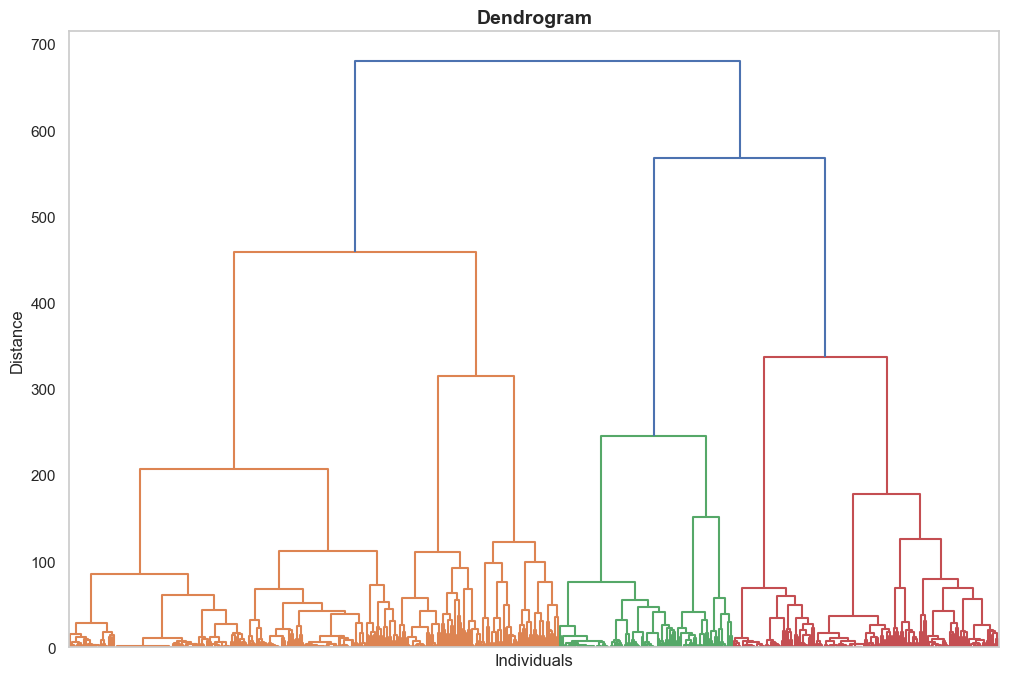

In [8]:
cluster = Cluster(om, sequence_data.ids, clustering_method='ward')
cluster.plot_dendrogram(xlabel="Individuals", ylabel="Distance")

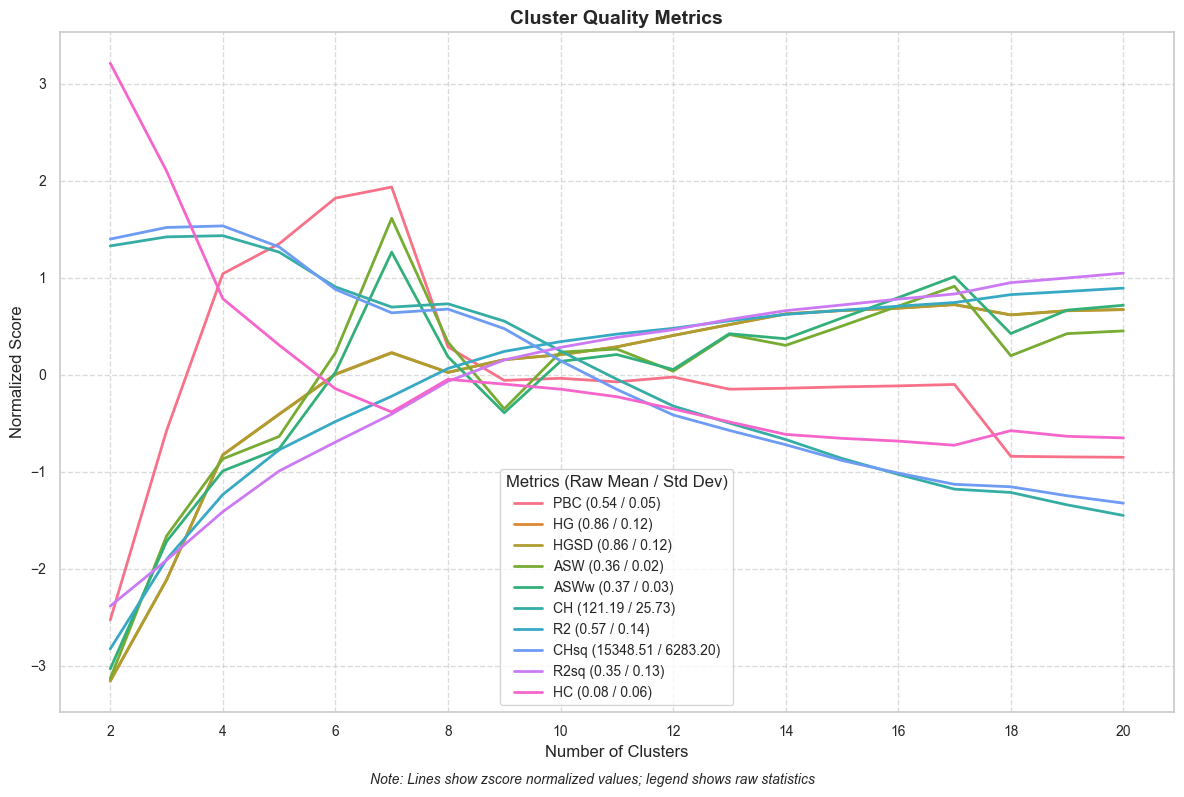

  Metric  Opt. Clusters     Raw Value  Z-Score Norm.
0    PBC              7      0.639790       1.935880
1     HG             17      0.949393       0.723151
2   HGSD             17      0.946875       0.725836
3    ASW              7      0.395299       1.614080
4   ASWw              7      0.401264       1.265220
5     CH              4    158.100358       1.434810
6     R2             20      0.697354       0.894374
7   CHsq              4  24995.723206       1.535398
8   R2sq             20      0.486303       1.048923
9     HC              2      0.260929       3.212215


In [9]:
# Create a ClusterQuality object to evaluate clustering quality
cluster_quality = ClusterQuality(cluster)
cluster_quality.compute_cluster_quality_scores()
cluster_quality.plot_cqi_scores(norm='zscore')
summary_table = cluster_quality.get_cqi_table()
print(summary_table)

In [11]:
cluster_quality.get_cluster_range_table()

,PBC,HG,HGSD,ASW,ASWw,CH,R2,CHsq,R2sq,HC
Cluster,,,,,,,,,,
cluster2,0.409455,0.473330,0.468118,0.283013,0.284935,155.383029,0.179554,24143.885757,0.032240,0.260929
cluster3,0.510153,0.601360,0.596467,0.317782,0.320511,157.783465,0.308000,24895.621681,0.094864,0.198107
cluster4,0.593675,0.759692,0.755316,0.336602,0.340181,158.100358,0.401168,24995.723206,0.160936,0.123666
cluster5,0.609593,0.811153,0.806942,0.342059,0.346379,153.742010,0.465191,23636.605728,0.216403,0.096663
cluster6,0.633907,0.861690,0.857728,0.362469,0.367706,144.518946,0.505808,20885.725658,0.255842,0.071223
cluster7,0.639790,0.888888,0.885129,0.395299,0.401264,139.168260,0.542211,19367.804456,0.293992,0.057633
cluster8,0.554750,0.863968,0.860345,0.365082,0.372060,140.034865,0.582008,19609.763356,0.338734,0.076713
cluster9,0.536917,0.879950,0.876559,0.348789,0.356426,135.443609,0.606504,18344.971285,0.367847,0.073879
cluster10,0.538030,0.886293,0.882950,0.362649,0.370771,127.535471,0.620503,16265.296466,0.385025,0.070954
